**Задание 1**


Используя исторические данные на листе «Timeseries» (см. Задания_1_2.xlsx), построить модель временного ряда.  Спрогнозировать  ежедневное поведение ряда в следующие 3 мес.  Пояснить выбор метода прогнозирования. Привести оценки качества прогноза.

In [2]:
import pandas as pd
import datetime
import seaborn as sns
%pylab inline
import matplotlib.pyplot as plt
import statsmodels
import statsmodels.api as sm
from fbprophet import Prophet
from scipy import stats
from datetime import datetime, timedelta
from itertools import product
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import mean_absolute_error
import warnings
warnings.filterwarnings('ignore') 

Populating the interactive namespace from numpy and matplotlib


In [3]:
ts = pd.read_excel("Задания_1_2.xlsx", sheet_name = 'Timeseries')

In [4]:
#Изучим данные
ts.head()

,Date,series1
0,2015-01-01,1006.699649
1,2015-01-02,3197.751826
2,2015-01-03,3217.491035
3,2015-01-04,2151.573759
4,2015-01-05,4243.929892


In [5]:
ts.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1642 entries, 0 to 1641
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Date     1642 non-null   object 
 1   series1  1642 non-null   float64
dtypes: float64(1), object(1)
memory usage: 25.8+ KB


In [6]:
#Преобразуем поле Date к типу данных datetime64
ts['Date'] = ts['Date'].apply(lambda x:datetime.strptime(x, '%Y-%m-%d'))

In [7]:
#Проверим
ts.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1642 entries, 0 to 1641
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   Date     1642 non-null   datetime64[ns]
 1   series1  1642 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 25.8 KB


In [8]:
#Присвоим индекс даты
ts.index = ts['Date']
#Удалим столбец Date
ts = ts.drop(["Date"], axis=1)

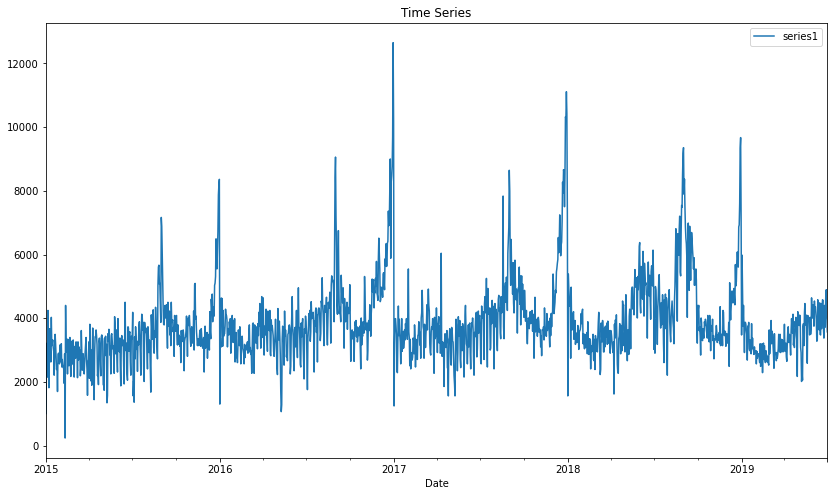

In [9]:
ts.plot(figsize=(14, 8), title="Time Series")
plt.show()

По данному графику можно сказать, что тренд и сезонность отсутствуют. Сильновыделяющиеся значения возможно могут быть аномалиями. 

In [10]:
#Проверим данные на пропуски
ts.isna().sum()

series1    0
dtype: int64

In [11]:
#Посмотрим на характеристики данных
ts.describe()

,series1
count,1642.000000
mean,3854.975154
std,1237.337605
min,236.870506
25%,3138.534200
50%,3632.014420
75%,4258.734299
max,12652.832842


Среднее примерно равно медиане, это говорит о том, что данные тяготеют к среднему, однако макс значениe очень большое, необходимо разобраться с аномалиями. А также достаточно std больше  по сравнению со средним.

Text(0.5, 0, 'Series')

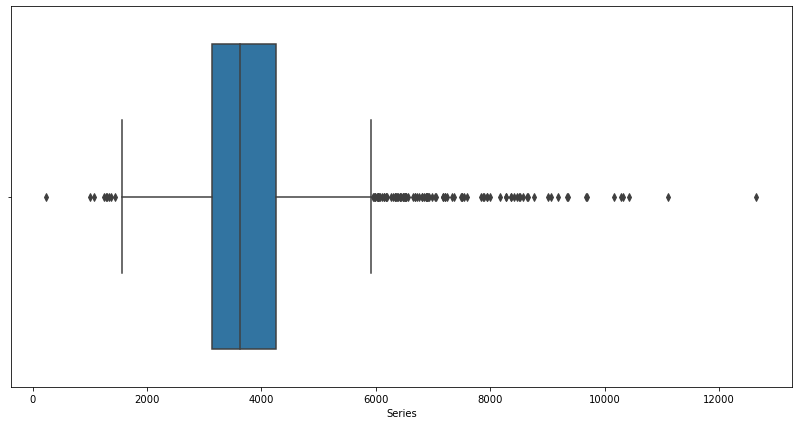

In [12]:
#Построим ящик с усами и посмотрим на сильно выделяющиеся значения и выявим аномалии
plt.figure(figsize=(14,7))
sns.boxplot(x=ts['series1'])
plt.xlabel("Series")

Все, что находится за пределми усов диаграммы размаха-это аномалии. Однако в данном случае их слишком много. Посмотрим на сильно выбивающиеся значения

In [13]:
left_anomaly = ts[ts['series1'] < 1000]
right_anomaly = ts[ts['series1'] > 10000]

Данные значения можно заменить, например, средним за последние 3 дня

In [14]:
#Запишем индексы аномальных значений в список
lst_indexes = []
for index in left_anomaly.index:
    lst_indexes.append(index)
    print(index)
for index in right_anomaly.index:
    lst_indexes.append(index)    

2015-02-10 00:00:00


In [15]:
#Посмотрим на аномалии до преобразования
for date in lst_indexes:
    print(ts.loc[date, :])

series1    236.870506
Name: 2015-02-10 00:00:00, dtype: float64
series1    12652.832842
Name: 2016-12-30 00:00:00, dtype: float64
series1    10165.692533
Name: 2016-12-31 00:00:00, dtype: float64
series1    10323.606204
Name: 2017-12-27 00:00:00, dtype: float64
series1    10284.127786
Name: 2017-12-28 00:00:00, dtype: float64
series1    11113.174556
Name: 2017-12-29 00:00:00, dtype: float64
series1    10422.302248
Name: 2017-12-30 00:00:00, dtype: float64


In [16]:
#Заменим данные аномальные значения средним за предыдущие 3 дня 
dif1 = timedelta(days = 1)
dif2 = timedelta(days = 2)
dif3 = timedelta(days = 3)
for date in lst_indexes:
    ts.loc[date, :] = (ts.loc[date-dif1, :] + ts.loc[date-dif2, :] + ts.loc[date-dif3, :]) / 3

In [17]:
#Посмотрим на аномалии после преобразования
for date in lst_indexes:
    print(ts.loc[date, :])

series1    2421.342946
Name: 2015-02-10 00:00:00, dtype: float64
series1    8974.760269
Name: 2016-12-30 00:00:00, dtype: float64
series1    9143.640166
Name: 2016-12-31 00:00:00, dtype: float64
series1    8198.351389
Name: 2017-12-27 00:00:00, dtype: float64
series1    8075.529646
Name: 2017-12-28 00:00:00, dtype: float64
series1    8267.073079
Name: 2017-12-29 00:00:00, dtype: float64
series1    8180.318038
Name: 2017-12-30 00:00:00, dtype: float64


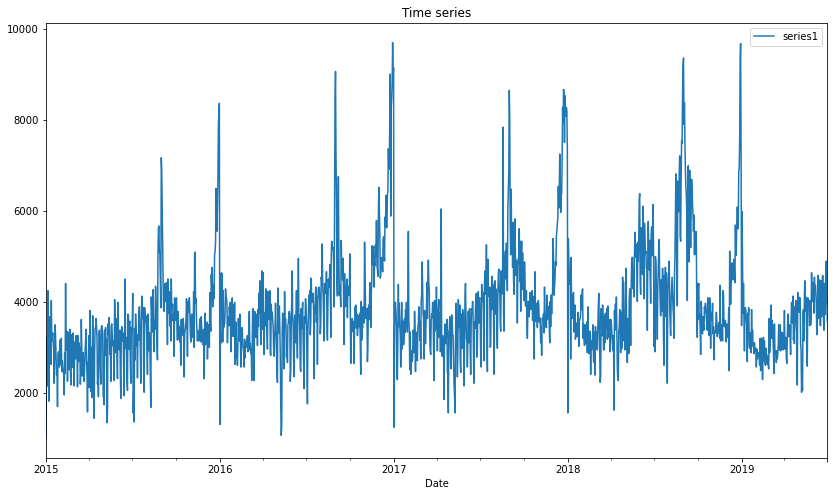

In [18]:
#Посмотрим сейчас, как выглядит временной ряд, после преобразования
ts.plot(figsize=(14, 8), title="Time series")
plt.show()

Глядя на график, можно наблюдать пики в конце каждого года, а также пики после второй половины года.

## ARIMA

<Figure size 720x504 with 0 Axes>

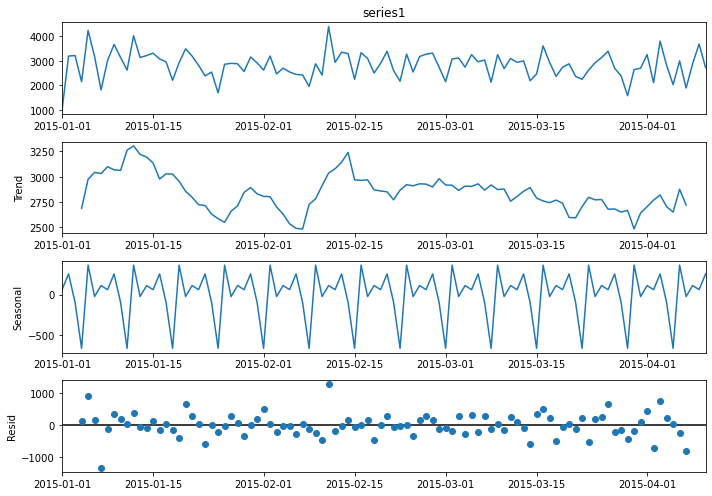

In [19]:
#Посмотрим на 50 наблюдений из этого набора
plt.figure(figsize(10,7))
sm.tsa.seasonal_decompose(ts.series1[:100]).plot()
plt.show()

In [20]:
#Посчитаем критерий Дики-Фуллера
print ("Критерий Дики-Фулера: p=%f" % sm.tsa.stattools.adfuller(ts)[1])

Критерий Дики-Фулера: p=0.000004


Критерий Дики-Фулера меньше 5%, что говорит о том, что ряд можно считать стационарным, такой ряд можно прогнозировать. Воспользуемся методом ARIMA.

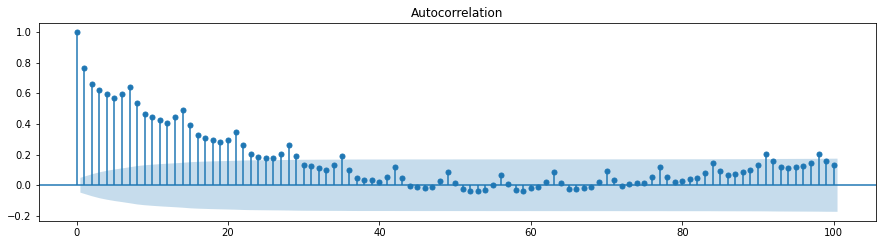

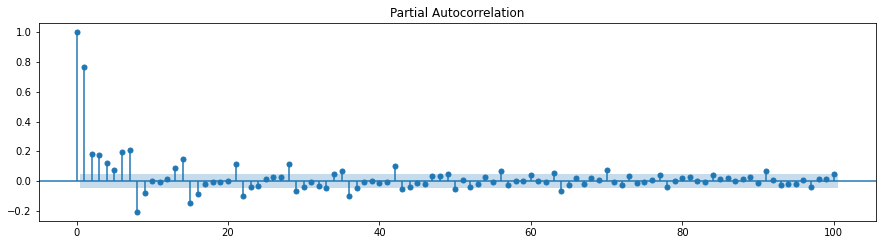

In [21]:
#Построим корреляционную и частично корреляционную функцию для подбора параметров модели
plt.figure(figsize=(15,8))
ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(ts.values.squeeze(), lags = 100, ax = ax )
pylab.show()
plt.figure(figsize=(15,8))
ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(ts.values.squeeze(), lags = 100, ax = ax )
pylab.show()

Подберем параметры для перебора моделей. Поскольку ряд изначально определен, как стационарный (его не нужно дифференцировать), а также выявлена сезонность (каждые 7 периодов), построим модель SARIMAX

In [22]:
ps = range(1,3)
d = 0
qs = range(1,3)
Ps = range(1,3)
D = 0
Qs = range(1,3)

In [23]:
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
print(f"Переберем {len(parameters_list)} моделей")

Переберем 16 моделей


In [24]:
results = []


best_aic = float("inf")
warnings.filterwarnings('ignore')

for param in parameters_list:
    try:
        model = sm.tsa.statespace.SARIMAX(ts.series1, order = (param[0], 0, param[1]), 
                                          seasonal_order = (param[2], 0, param[3], 7)).fit(disp=-1)
    
    except:
            print ('wrong parameters:', param)
            continue    
    aic = model.aic
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])    
    
warnings.filterwarnings('default')

In [25]:
result_table = pd.DataFrame(results)
result_table.columns = ['parameters','aic']
print (result_table.sort_values(by='aic', ascending=[True]).head())

      parameters           aic
11  (2, 1, 2, 2)  25912.342181
3   (1, 1, 2, 2)  25916.044324
6   (1, 2, 2, 1)  25916.692976
9   (2, 1, 1, 2)  25917.877041
5   (1, 2, 1, 2)  25918.246068


Критерий Стьюдента: p=0.065010
Критерий Дики-Фулера: p=0.000000


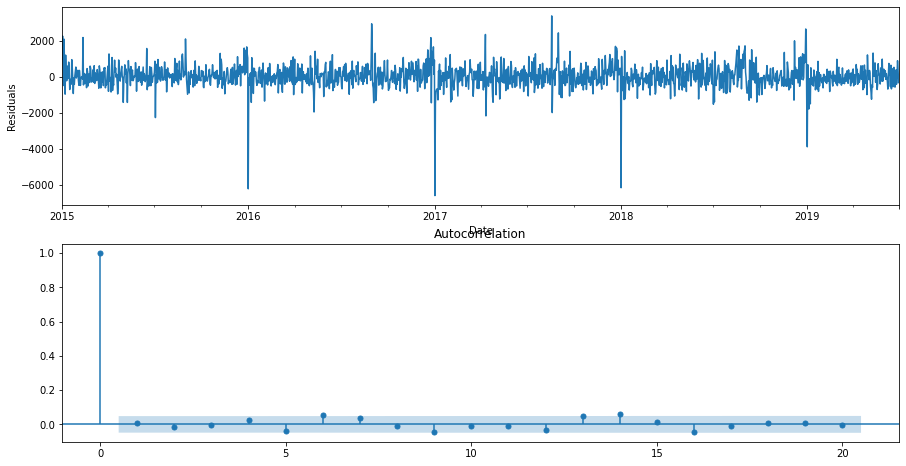

In [26]:
#Анализ остатков
plt.figure(figsize(15,8))
plt.subplot(211)
best_model.resid.plot()
plt.ylabel(u'Residuals')
ax = plt.subplot(212)
sm.graphics.tsa.plot_acf(best_model.resid.values.squeeze(), lags = 20, ax=ax)
print ("Критерий Стьюдента: p=%f" % stats.ttest_1samp(best_model.resid,0)[1])
print ("Критерий Дики-Фулера: p=%f" % sm.tsa.stattools.adfuller(best_model.resid)[1])

Критерий Стьюдента говорит о том, что остатки несмещенны, то есть в среднем равным нулю.
Критерий Стьюдента говорит о том, что остатки стационарны.
Значит данная модель достаточна хороша.

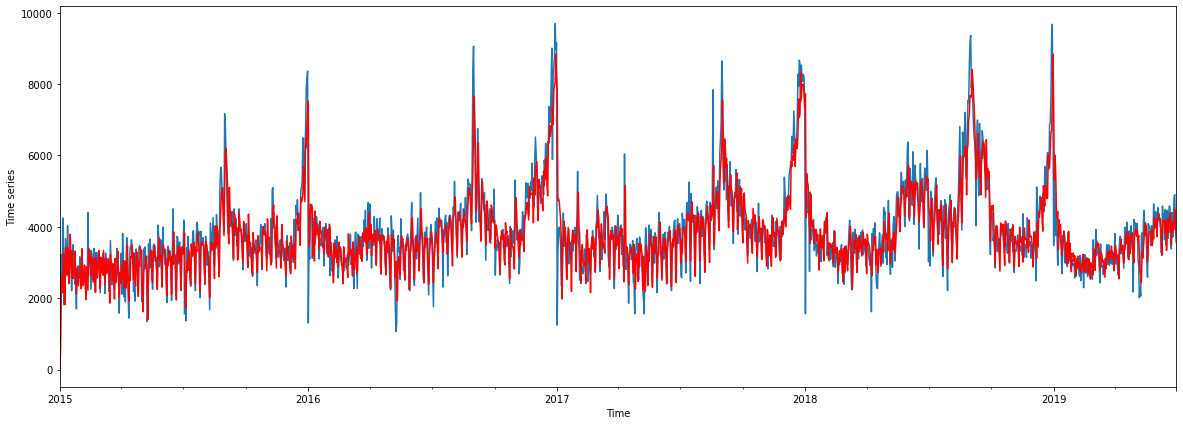

In [27]:
#Посмотрим, как модель описывает данные
ts['model'] = best_model.fittedvalues
plt.figure (figsize(20,7))
ts.series1.plot()
ts.model.plot(color='r')
plt.xlabel("Time")
plt.ylabel('Time series')
pylab.show()

Модель достаточно хорошо описывает данные(красная линия).

In [28]:
#Спргнозируем ежедневное поведение ряда на 3 месяца вперед
ts1 = ts[['series1']]
date_list = [datetime.strptime('2019-07-01', '%Y-%m-%d') + relativedelta(days = x) for x in range(0,92)]
future = pd.DataFrame (index=date_list, columns = ts1.columns)
ts1 = pd.concat([ts1, future])
ts1['forecast'] = best_model.predict(start=1642, end=1734)
warnings.filterwarnings('ignore') 

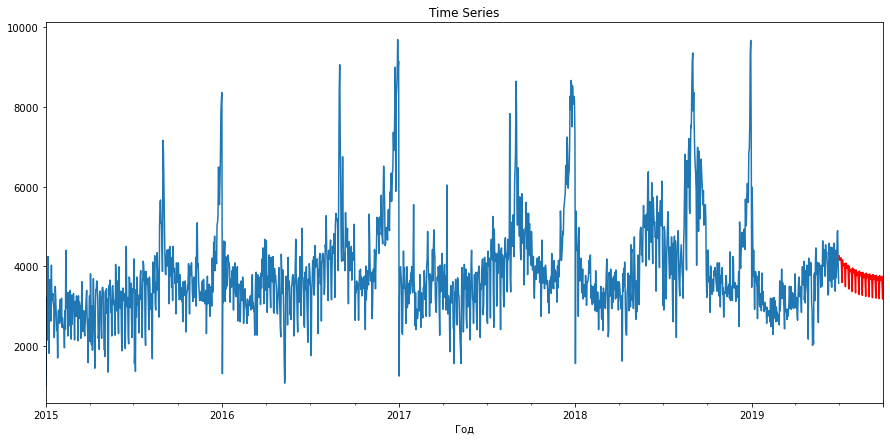

In [29]:
#Отобразим на графике
plt.figure(figsize(15,7))
ts1.series1.plot()
ts1.forecast.plot(color='r')
plt.title('Time Series')
plt.xlabel('Год')
pylab.show()

Для оценки качества модели отрежем 91 последнее наблюдение(то есть за последние 3 месяца), построим прогноз и посчитаем ошибки MAPE и MAE

In [30]:
ts_quality = ts[:-91]
ts_quality1 = ts_quality[['series1']]
date_list = [datetime.strptime('2019-04-01', '%Y-%m-%d') + relativedelta(days = x) for x in range(0,91)]
future = pd.DataFrame (index=date_list, columns = ts_quality1.columns)
ts_quality1 = pd.concat([ts_quality1, future])
ts_quality1['forecast'] = best_model.predict(start=1551, end=1642)

In [31]:
y_true = ts[-91:]['series1']
y_pred = ts_quality1[-91:]['forecast']

In [32]:
print(f"Ошибка прогноза в процентах: {round(mean_absolute_percentage_error(y_true, y_pred) * 100,2)} %")
print(f"Ошибка прогноза в абсолютных величинах: {round(mean_absolute_error(y_true, y_pred), 2)}")

Ошибка прогноза в процентах: 11.5 %
Ошибка прогноза в абсолютных величинах: 401.11


Гляда на график, прогноз выглядит адекватным, после плавного подъема следует спад, модель выловила сезонность, а также колебания в пределах одного дня.

In [33]:
pd.Series(ts1['forecast'][-92:]).to_csv("prediction_vector_task1.csv", header=False, index=False)

## Fbprophet

In [81]:
ts = ts.reset_index()
ts.set_axis(['ds', 'y'], axis=1, inplace=True)
ts_quality = ts.copy()
y_true = ts[-91:]

In [20]:
model = Prophet(daily_seasonality=True) 
model.fit(ts) 
future = model.make_future_dataframe(periods=92)  
forecast = model.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]
warnings.filterwarnings("ignore")

In [21]:
forecast

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2015-01-01,1439.868183,3979.423740,5853.967115,1439.868183,1439.868183,3482.573708,3482.573708,3482.573708,1736.466141,...,176.594705,176.594705,176.594705,1569.512863,1569.512863,1569.512863,0.0,0.0,0.0,4922.441891
1,2015-01-02,1441.080739,3777.939027,5757.764289,1441.080739,1441.080739,3314.637152,3314.637152,3314.637152,1736.466141,...,184.572021,184.572021,184.572021,1393.598991,1393.598991,1393.598991,0.0,0.0,0.0,4755.717891
2,2015-01-03,1442.293295,3293.066340,5194.977960,1442.293295,1442.293295,2790.090233,2790.090233,2790.090233,1736.466141,...,-157.208023,-157.208023,-157.208023,1210.832115,1210.832115,1210.832115,0.0,0.0,0.0,4232.383528
3,2015-01-04,1443.505852,2430.684042,4471.435807,1443.505852,1443.505852,2043.013747,2043.013747,2043.013747,1736.466141,...,-717.545111,-717.545111,-717.545111,1024.092717,1024.092717,1024.092717,0.0,0.0,0.0,3486.519599
4,2015-01-05,1444.718408,3250.954405,5195.947209,1444.718408,1444.718408,2736.926611,2736.926611,2736.926611,1736.466141,...,164.207369,164.207369,164.207369,836.253101,836.253101,836.253101,0.0,0.0,0.0,4181.645019
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1729,2019-09-26,1930.711098,3042.402908,4989.349856,1920.469507,1944.584897,2045.462599,2045.462599,2045.462599,1736.466141,...,176.594705,176.594705,176.594705,132.401754,132.401754,132.401754,0.0,0.0,0.0,3976.173697
1730,2019-09-27,1929.206233,2936.420822,4882.919679,1918.813450,1943.356224,2020.374273,2020.374273,2020.374273,1736.466141,...,184.572021,184.572021,184.572021,99.336112,99.336112,99.336112,0.0,0.0,0.0,3949.580507
1731,2019-09-28,1927.701368,2629.240393,4532.537017,1917.080894,1942.127550,1651.939549,1651.939549,1651.939549,1736.466141,...,-157.208023,-157.208023,-157.208023,72.681431,72.681431,72.681431,0.0,0.0,0.0,3579.640917
1732,2019-09-29,1926.196503,2037.846422,3966.190635,1915.409939,1940.904090,1070.425860,1070.425860,1070.425860,1736.466141,...,-717.545111,-717.545111,-717.545111,51.504830,51.504830,51.504830,0.0,0.0,0.0,2996.622364


In [22]:
our_model = forecast.yhat[:-92]
ts['model'] = our_model
ts.index = ts.ds
del ts['ds']

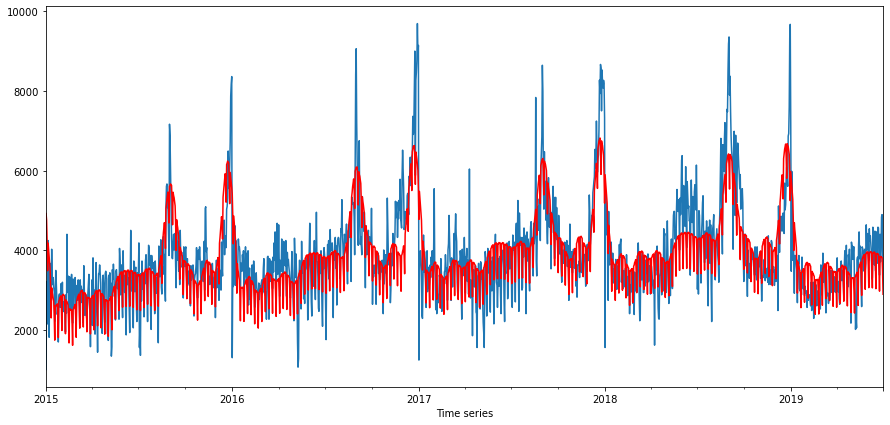

In [24]:
plt.figure(figsize(15,7))
ts.y.plot()
ts.model.plot(color='r')
plt.xlabel('Time series')
pylab.show()

In [25]:
predictions = forecast.iloc[-92:]
predictions = predictions[['ds', 'yhat']]
predictions.index = predictions.ds
del predictions['ds']

In [26]:
ts2 = ts[['y']]
date_list = [datetime.strptime('2019-07-01', '%Y-%m-%d') + relativedelta(days = x) for x in range(0,92)]
future = pd.DataFrame (index=date_list, columns = ts2.columns)
ts2 = pd.concat([ts2, future])
ts2['forecast'] = predictions

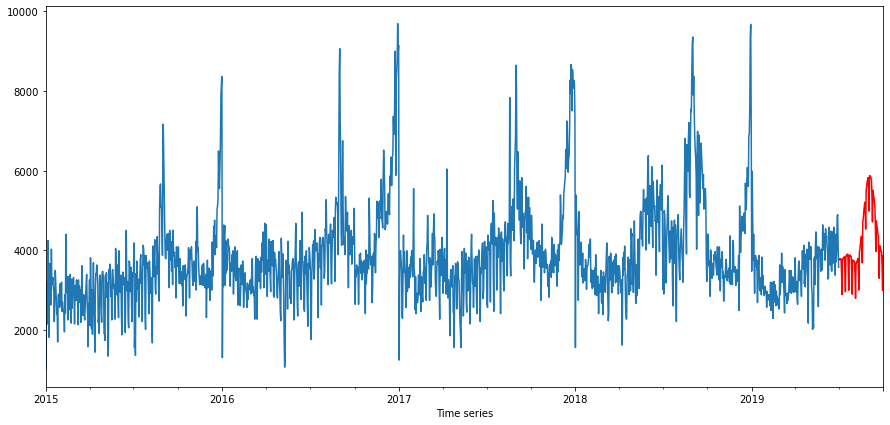

In [27]:
plt.figure(figsize(15,7))
ts2.y.plot()
ts2.forecast.plot(color='r')
plt.xlabel('Time series')
pylab.show()

In [82]:
ts_quality = ts_quality[:-91]

In [83]:
ts_quality

,ds,y
0,2015-01-01,1006.699649
1,2015-01-02,3197.751826
2,2015-01-03,3217.491035
3,2015-01-04,2151.573759
4,2015-01-05,4243.929892
...,...,...
1546,2019-03-27,2960.881320
1547,2019-03-28,3316.187079
1548,2019-03-29,2941.142112
1549,2019-03-30,3079.316573


In [103]:
model = Prophet(daily_seasonality=True, yearly_seasonality=True)
model.fit(ts_quality) 
future = model.make_future_dataframe(periods=91)  
forecast = model.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]

,ds,yhat,yhat_lower,yhat_upper
0,2015-01-01,4956.236910,4064.186879,5912.615350
1,2015-01-02,4781.822642,3802.722161,5717.355272
2,2015-01-03,4262.479747,3323.237340,5273.012313
3,2015-01-04,3505.459605,2522.683522,4497.230337
4,2015-01-05,4206.604638,3231.612077,5190.131292
...,...,...,...,...
1637,2019-06-26,3405.272725,2454.091865,4393.011034
1638,2019-06-27,3379.269894,2429.343236,4370.935248
1639,2019-06-28,3370.851450,2472.367248,4380.712107
1640,2019-06-29,3025.354908,2058.323964,3950.585340


In [104]:
y_pred = forecast[['ds', 'yhat']][-91:]

In [105]:
y_true

,ds,y
1551,2019-04-01,3809.667299
1552,2019-04-02,2960.881320
1553,2019-04-03,2960.881320
1554,2019-04-04,3217.491035
1555,2019-04-05,2783.228441
...,...,...
1637,2019-06-26,4007.059387
1638,2019-06-27,4836.106157
1639,2019-06-28,4895.323783
1640,2019-06-29,4086.016222


In [106]:
y_pred

,ds,yhat
1551,2019-04-01,3220.746687
1552,2019-04-02,3230.155968
1553,2019-04-03,3276.685610
1554,2019-04-04,3270.243628
1555,2019-04-05,3280.615589
...,...,...
1637,2019-06-26,3405.272725
1638,2019-06-27,3379.269894
1639,2019-06-28,3370.851450
1640,2019-06-29,3025.354908


In [107]:
print(f"Ошибка прогноза в процентах: {round(mean_absolute_percentage_error(y_true['y'], y_pred['yhat']) * 100,2)} %")
print(f"Ошибка прогноза в абсолютных величинах: {round(mean_absolute_error(y_true['y'], y_pred['yhat']), 2)}")

Ошибка прогноза в процентах: 18.31 %
Ошибка прогноза в абсолютных величинах: 689.49
